Prepare data

In [1]:
"""
Clean your text to create normalized text represenations.
"""

import logging
import re
import sys
from unicodedata import category

from emoji import UNICODE_EMOJI, demojize, emojize
from ftfy import fix_text

from cleantext import constants
from cleantext.specials import save_replace
from cleantext.utils import remove_substrings

log = logging.getLogger()

# fall back to `unicodedata`
try:
    from unidecode import unidecode

except ImportError:
    from unicodedata import normalize

    unidecode = lambda x: normalize("NFD", x).encode("ASCII", "ignore").decode("utf-8")
    log.warning(
        "Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results."
    )


def fix_strange_quotes(text):
    """
    Replace strange quotes, i.e., 〞with a single quote ' or a double quote " if it fits better.
    """
    text = constants.SINGLE_QUOTE_REGEX.sub("'", text)
    text = constants.DOUBLE_QUOTE_REGEX.sub('"', text)
    return text


def fix_bad_unicode(text, normalization="NFC"):
    """
    Fix unicode text that's "broken" using `ftfy <http://ftfy.readthedocs.org/>`_;
    this includes mojibake, HTML entities and other code cruft,
    and non-standard forms for display purposes.
    Args:
        text (str): raw text
        normalization ({'NFC', 'NFKC', 'NFD', 'NFKD'}): if 'NFC',
            combines characters and diacritics written using separate code points,
            e.g. converting "e" plus an acute accent modifier into "é"; unicode
            can be converted to NFC form without any change in its meaning!
            if 'NFKC', additional normalizations are applied that can change
            the meanings of characters, e.g. ellipsis characters will be replaced
            with three periods
    """
    # trying to fix backslash-replaced strings (via https://stackoverflow.com/a/57192592/4028896)
    try:
        text = text.encode("latin", "backslashreplace").decode("unicode-escape")
    except:
        pass

    return fix_text(text, normalization=normalization)


def to_ascii_unicode(text, lang="en", no_emoji=False):
    """
    Try to represent unicode data in ascii characters similar to what a human
    with a US keyboard would choose.
    Works great for languages of Western origin, worse the farther the language
    gets from Latin-based alphabets. It's based on hand-tuned character mappings
    that also contain ascii approximations for symbols and non-Latin alphabets.
    """
    # normalize quotes before since this improves transliteration quality
    text = fix_strange_quotes(text)

    if not no_emoji:
        text = demojize(text, use_aliases=True)

    lang = lang.lower()
    # special handling for German text to preserve umlauts
    if lang == "de":
        text = save_replace(text, lang=lang)

    text = unidecode(text)

    # important to remove utility characters
    if lang == "de":
        text = save_replace(text, lang=lang, back=True)

    if not no_emoji:
        text = emojize(text, use_aliases=True)

    return text


def normalize_whitespace(
    text, no_line_breaks=False, strip_lines=True, keep_two_line_breaks=False
):
    """
    Given ``text`` str, replace one or more spacings with a single space, and one
    or more line breaks with a single newline. Also strip leading/trailing whitespace.
    """
    if strip_lines:
        text = "\n".join([x.strip() for x in text.splitlines()])

    if no_line_breaks:
        text = constants.MULTI_WHITESPACE_TO_ONE_REGEX.sub(" ", text)
    else:
        if keep_two_line_breaks:
            text = constants.NONBREAKING_SPACE_REGEX.sub(
                " ", constants.TWO_LINEBREAK_REGEX.sub(r"\n\n", text)
            )
        else:
            text = constants.NONBREAKING_SPACE_REGEX.sub(
                " ", constants.LINEBREAK_REGEX.sub(r"\n", text)
            )

    return text.strip()


# used below to keep `normalize_whitespace` as a parameter in `clean`
def _normalize_whitespace(*kwargs):
    return normalize_whitespace(*kwargs)


def replace_urls(text, replace_with="<URL>"):
    """
    Replace all URLs in ``text`` str with ``replace_with`` str.
    """
    return constants.URL_REGEX.sub(replace_with, text)


def replace_emails(text, replace_with="<EMAIL>"):
    """
    Replace all emails in ``text`` str with ``replace_with`` str.
    """
    return constants.EMAIL_REGEX.sub(replace_with, text)


def replace_phone_numbers(text, replace_with="<PHONE>"):
    """
    Replace all phone numbers in ``text`` str with ``replace_with`` str.
    """
    return constants.PHONE_REGEX.sub(replace_with, text)


def replace_numbers(text, replace_with="<NUMBER>"):
    """
    Replace all numbers in ``text`` str with ``replace_with`` str.
    """
    return constants.NUMBERS_REGEX.sub(replace_with, text)


def replace_digits(text, replace_with="0"):
    """
    Replace all digits in ``text`` str with ``replace_with`` str, i.e., 123.34 to 000.00
    """
    return re.sub(r"\d", replace_with, text)


def replace_currency_symbols(text, replace_with="<CUR>"):
    """
    Replace all currency symbols in ``text`` str with string specified by ``replace_with`` str.
    Args:
        text (str): raw text
        replace_with (str): if None (default), replace symbols with
            their standard 3-letter abbreviations (e.g. '$' with 'USD', '£' with 'GBP');
            otherwise, pass in a string with which to replace all symbols
            (e.g. "*CURRENCY*")
    """
    if replace_with is None:
        for k, v in constants.CURRENCIES.items():
            text = text.replace(k, v)
        return text
    else:
        return constants.CURRENCY_REGEX.sub(replace_with, text)


def replace_punct(text, replace_with=" "):
    """
    Replace punctuations from ``text`` with whitespaces (or other tokens).
    """
    return text.translate(
        dict.fromkeys(
            (i for i in range(sys.maxunicode) if category(chr(i)).startswith("P")),
            replace_with,
        )
    )


def remove_punct(text):
    """
    Remove punctuations from ``text``.
    """
    return text.translate(constants.PUNCT_TRANSLATE_UNICODE)


def remove_emoji(text):
    return remove_substrings(text, UNICODE_EMOJI["en"])


def clean(
    text,
    fix_unicode=True,
    to_ascii=True,
    lower=True,
    normalize_whitespace=True,
    no_line_breaks=False,
    strip_lines=True,
    keep_two_line_breaks=False,
    no_urls=False,
    no_emails=False,
    no_phone_numbers=False,
    no_numbers=False,
    no_digits=False,
    no_currency_symbols=False,
    no_punct=False,
    no_emoji=False,
    replace_with_url="<URL>",
    replace_with_email="<EMAIL>",
    replace_with_phone_number="<PHONE>",
    replace_with_number="<NUMBER>",
    replace_with_digit="0",
    replace_with_currency_symbol="<CUR>",
    replace_with_punct="",
    lang="en",
):
    """
    Normalize various aspects of a raw text. A convenience function for applying all other preprocessing functions in one go.
    Args:
        text (str): raw text to preprocess
        fix_unicode (bool): if True, fix "broken" unicode such as
            mojibake and garbled HTML entities
        to_ascii (bool): if True, convert non-to_ascii characters
            into their closest to_ascii equivalents
        lower (bool): if True, all text is lower-cased
        no_line_breaks (bool): if True, strip line breaks from text
        no_urls (bool): if True, replace all URL strings with a special URL token
        no_emails (bool): if True, replace all email strings with a special EMAIL token
        no_phone_numbers (bool): if True, replace all phone number strings
            with a special PHONE token
        no_numbers (bool): if True, replace all number-like strings
            with a special NUMBER token
        no_digits (bool): if True, replace all digits with a special DIGIT token
        no_currency_symbols (bool): if True, replace all currency symbols
            with a special CURRENCY token
        no_punct (bool): if True, remove all punctuation (replace with
            empty string)
        replace_with_url (str): special URL token, default "<URL>",
        replace_with_email (str): special EMAIL token, default "<EMAIL>",
        replace_with_phone_number (str): special PHONE token, default "<PHONE>",
        replace_with_number (str): special NUMBER token, default "<NUMBER>",
        replace_with_digit (str): special DIGIT token, default "0",
        replace_with_currency_symbol (str): special CURRENCY token, default "<CUR>",
        replace_with_punct (str): replace punctuations with this token, default "",
        lang (str): special language-depended preprocessing. Besides the default English ('en'), only German ('de') is supported

    Returns:
        str: input ``text`` processed according to function args
    """

    if text is None:
        return ""

    text = str(text)

    if fix_unicode:
        text = fix_bad_unicode(text)
    if no_currency_symbols:
        text = replace_currency_symbols(text, replace_with_currency_symbol)
    if to_ascii:
        text = to_ascii_unicode(text, lang=lang, no_emoji=no_emoji)
    if no_urls:
        text = replace_urls(text, replace_with_url)
    if no_emails:
        text = replace_emails(text, replace_with_email)
    if no_phone_numbers:
        text = replace_phone_numbers(text, replace_with_phone_number)
    if no_numbers:
        text = replace_numbers(text, replace_with_number)
    if no_digits:
        text = replace_digits(text, replace_with_digit)
    if no_punct:
        if replace_with_punct == "":
            text = remove_punct(text)
        else:
            text = replace_punct(text, replace_with_punct)

    if no_emoji and not to_ascii:
        text = remove_emoji(text)

    if lower:
        text = text.lower()

    if normalize_whitespace:
        text = _normalize_whitespace(
            text, no_line_breaks, strip_lines, keep_two_line_breaks
        )

    return text


In [2]:
def mycleaner(text):
    text = fix_strange_quotes(text)
    text = fix_bad_unicode(text)
    text = replace_currency_symbols(text)
    text = replace_urls(text)
    text = replace_emails(text)
    text = replace_phone_numbers(text)
    text = replace_numbers(text)
    text = replace_digits(text)
    text = remove_emoji(text)
    text = _normalize_whitespace(text)
    return text

In [3]:
import os
a = os.listdir('data')
import ujson
X = []
y = []
for i in a:
  with open(f'data/{i}', encoding='utf8') as f:
        ls = ujson.load(f)
  for l in range(1757):
        if 'snippet' in ls[l].keys():
            X.append(ls[l]['message']+ls[l]['snippet'])
            y.append(i)
        else:
            X.append(ls[l]['message'])
            y.append(i)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data'

In [ ]:
X_clean = []
for i in X:
    X_clean.append(mycleaner(i))

In [ ]:
with open('stopword.txt', encoding='utf8') as f:
    stopwords = f.readlines()
stopwords = [x.strip().replace(' ', '_') for x in stopwords]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1, 2), stop_words=stopwords) 

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=16)

In [ ]:
fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

Linear SVC

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
model = LinearSVC(C=1, multi_class='crammer_singer').fit(tfidf_vectorizer_vectors, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [ ]:
data = 'Năm 2019, bàn thắng vàng của Huỳnh Như giúp Việt Nam đánh bại Thái Lan 1-0 để trở lại ngôi vô địch AFF Cup. Cũng với lực lượng nòng cốt đó, Việt Nam vô địch SEA Games 30, SEA Games 31 và đoạt vé dự World Cup 2023.Vì vậy, thầy trò HLV Mai Đức Chung tiếp tục là ứng viên nặng ký, khi đến với giải đấu ở Philippines. Dù thiếu trung vệ Chương Thị Kiều chấn thương, trong khi Thu Thương và Diễm My ngồi ngoài vì lý do tương tự, Việt Nam vẫn được đánh giá cao vượt trội so với Campuchia. Ở lần gặp nhau gần nhất tại SEA Games hồi tháng 5, Việt Nam từng đè bẹp đối thủ 7-0.Bên cạnh Campuchia, các đối thủ còn lại trong bảng đấu là Myanmar, Timor Leste và Lào cũng nằm dưới tầm của Việt Nam. Theo cựu tiền đạo Đỗ Thị Ngọc Châm, việc rơi vào bảng đấu nhẹ giúp các đàn em tiết kiệm được nhiều sức lực cũng như thoải mái cho con đường vào bán kết. "Ở bảng đấu này, không có lý do gì để không nhất bảng", Ngọc Châm nói. "Các đội tuyển non trẻ như Campuchia, Timor Leste và Lào không phải là đối thủ của chúng ta. Việt Nam sẽ dễ dàng giành chiến thắng cách biệt. Chỉ Myanmar là có khả năng cạnh tranh ngôi đầu bảng, nhưng qua những gì thể hiện ở SEA Games 31 vừa qua, tôi tin Việt Nam sẽ đánh bại được đối thủ này".Chỉ có một khó khăn nhỏ cho Việt Nam là phải thi đấu trên sân cỏ nhân tạo Binan. Dù vậy, chính trên sân đấu này, Việt Nam từng toàn thắng ở SEA Games 30. Trong đội hình hiện tại có bảy cầu thủ TP HCM thường xuyên tập sân nhân tạo Tao Đàn'

In [ ]:
print(model.predict(fitted_vectorizer.transform([data])))

['content_thethao_mini.json']


In [ ]:
import pickle

In [ ]:
filename = 'finalized_model.pkl'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
filename = 'fitted_vectorizer.pkl'
pickle.dump(fitted_vectorizer, open(filename, 'wb'))

In [ ]:
from sklearn.metrics import accuracy_score
y_pred=model.predict(fitted_vectorizer.transform(X_test))
accuracy_score(y_test, y_pred)

0.7937777777777778

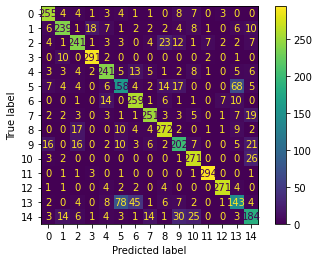

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp=ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))

disp.plot()
plt.show()

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average = None)

array([0.86003373, 0.81292517, 0.7862969 , 0.93418941, 0.80872483,
       0.55929204, 0.81574803, 0.84797297, 0.82926829, 0.69775475,
       0.84820031, 0.96710526, 0.9426087 , 0.5070922 , 0.64111498])

In [ ]:
model.score(fitted_vectorizer.transform(X_test), y_test)

0.7937777777777778

Multinomial Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
model1 = MultinomialNB(alpha=0.1).fit(tfidf_vectorizer_vectors, y_train)

In [ ]:
y_pred1=model1.predict(fitted_vectorizer.transform(X_test))
accuracy_score(y_test, y_pred1)

0.7555555555555555

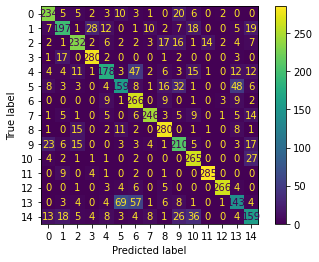

In [ ]:
disp=ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred1))

disp.plot()
plt.show()

In [ ]:
f1_score(y_test, y_pred1, average = None)

array([0.79456706, 0.68284229, 0.76694215, 0.89171975, 0.66294227,
       0.57400722, 0.75035261, 0.85268631, 0.8358209 , 0.67851373,
       0.80060423, 0.94527363, 0.94326241, 0.52094718, 0.57091562])